# Model Training

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
# import train_config as config







# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3 #0.001
EPOCHS = 25
BS = 16

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[Loading Images]")
imagePaths = list(paths.list_images("/content/dataset/"))
data = []
labels = []





# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)


print(f"Labels : {labels}")





# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size = 0.20, stratify=labels, random_state = 42)






# initialize the training data augmentation object
# to reduce overfitting
trainAug = ImageDataGenerator(
	rotation_range = 15,
	fill_mode = "nearest")

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
	layer.trainable = False



#----------------------------------------------------------------------



# compile our model
print("[Compiling Model]")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"]) #covid or normal

# train the head of the network
print("[Training the Model]")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


# serialize the model to disk
model.save("glass.h5", save_format="h5")
print("[Model Saved]")


[Loading Images]
Labels : []


ValueError: ignored

# **Product Defect Detection**

Non Defected: 94.69%


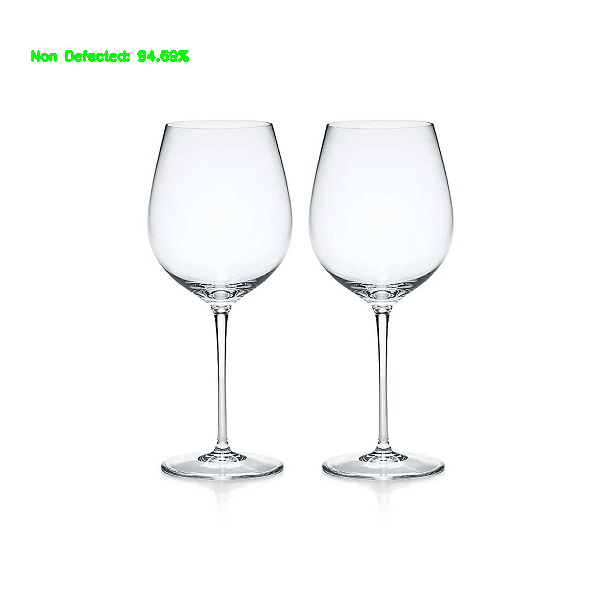

True

In [ ]:
 
import tensorflow.keras
from PIL import Image, ImageOps
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
 
# Disable scientific notation for clarity
np.set_printoptions(suppress=True)
 
# Load the model
model = tensorflow.keras.models.load_model('/content/glass.h5')
 
 
classes = ['Defected','Non Defected'] #These values will be used for showing output
 
# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)                           
 
# Replace this with the path to your image
img_path = '/content/non defected2.jpg'
image = Image.open(img_path)
 
#resize the image to a 224x224 with the same strategy as in TM2:
#resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.ANTIALIAS)
 
#turn the image into a numpy array
image_array = np.asarray(image)
 
# display the resized image
image.show()
 
# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
 
# Load the image into the array
data[0] = normalized_image_array
 
# run the inference
(defected, nonDefected) = model.predict(data)[0]
 
# determine the class label and color we'll use to draw
# the bounding box and text
label = "Defected" if defected > nonDefected else "Non Defected"
color = (0, 255, 0) if label == "Non Defected" else (0, 0, 255)
 
# include the probability in the label
label = "{}: {:.2f}%".format(label, max(defected, nonDefected) * 100)
 
print(label)
# display the label and bounding box rectangle on the output
# frame
image = cv2.imread(img_path)
cv2.putText(image, label, (30, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
cv2_imshow(image)
cv2.imwrite("/content/detected1.jpg",image)